# Hyperparameter optimization: simulated data

In this notebook we will inspect results of hyperparameter optimization on a simulated dataset. Previously, we run a grid search on a simulated dataset and saved resulting MAE to each node in the grid. The grid search procedure also saves the best model in `models/simulation_1`.

The procedure is done by running `hp_opt_sim.py` script from `src/models` by runnnig the following command from the root directory of the project:

```bash
python src/models/hp_opt_sim.py
```

Inside the script we defined a flag `proper_training`. Setting its value to `False` trains models on the whole training set (80% of the total dataset), amd otherwise, `proper_training=True` trains models on the "proper training set", which makes 60% of the original dataset and keep 20% of the original "training set" as calibration set for fitting conformal quantile regression. MAE is calculated on the last 20% of the original dataset, called the "validation set".

Here we will load the results and inspect them, to see if the optimal parameters are in a local minimum or if they are on the edge of the grid.

Entire analysis is done in "sample-wise" manner, where "samples" differ only in their size, which is relevant for the later comparison with the real data and assessing limits of the application of CP methods. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_absolute_error, make_scorer
import time
import pickle

## Preprocessing

In "Preprocessing" section we repeat preprocessing steps performed in `hp_opt_sim.py` script.

In [2]:
data = pd.read_csv('../data/simulated/simulation_1.csv')
data

,S,sigma,tau,r,K,sample_id,C
0,563.484917,0.283213,0.103238,0.024120,590.325872,0,10.623483
1,563.484917,0.283213,0.103238,0.024120,577.181074,0,15.116507
2,563.484917,0.283213,0.103238,0.024120,709.027220,0,0.115945
3,563.484917,0.283213,0.103238,0.024120,528.887423,0,42.717661
4,983.358919,0.800311,1.738972,0.026128,876.087273,0,443.136637
...,...,...,...,...,...,...,...
384995,953.651240,0.898391,0.935096,0.038669,1051.532656,5,301.089349
384996,695.038669,0.739430,1.129417,0.039003,774.132142,5,197.220673
384997,695.038669,0.739430,1.129417,0.039003,686.954716,5,225.992782
384998,695.038669,0.739430,1.129417,0.039003,676.509786,5,229.765122


The author assumed homogeneity of degree one in the spot and strike prices, and trained model(s) to learn the following mapping:

$$(S/K, \sigma, \tau, r) \mapsto C_{BS}/K $$

In [3]:
data['S'] = data['S']/data['K']
data['C'] = data['C']/data['K']
data.drop('K', axis=1, inplace=True)

In [4]:
data

,S,sigma,tau,r,sample_id,C
0,0.954532,0.283213,0.103238,0.024120,0,0.017996
1,0.976271,0.283213,0.103238,0.024120,0,0.026190
2,0.794730,0.283213,0.103238,0.024120,0,0.000164
3,1.065416,0.283213,0.103238,0.024120,0,0.080769
4,1.122444,0.800311,1.738972,0.026128,0,0.505813
...,...,...,...,...,...,...
384995,0.906915,0.898391,0.935096,0.038669,5,0.286334
384996,0.897829,0.739430,1.129417,0.039003,5,0.254764
384997,1.011768,0.739430,1.129417,0.039003,5,0.328978
384998,1.027389,0.739430,1.129417,0.039003,5,0.339633


In [5]:
# Split into samples by sample_id
sample_ids = data['sample_id'].unique()
samples = [data.loc[data['sample_id']==id] for id in sample_ids]
sample_lens = [len(sample) for sample in samples]

In [6]:
data_sets = {}

for sample in samples:
    id = sample['sample_id'].iloc[0]
    size = len(sample)
    sample = sample.drop('sample_id', axis=1)

    train, validation = train_test_split(sample, test_size=0.2, random_state=42)
    proper_train, calibration = train_test_split(train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

    data_sets[id] = [train, proper_train, calibration, validation]


In [7]:
# define grid search parameters from table 2

param_grid = {
    'n_estimators': [100, 500, 1000, 2500, 5000],
    'num_leaves': [32, 64, 128, 256],
    'max_depth': [8, 16, 32, 64],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5]
}

## Inspect MAE across the grid

In [8]:
# load csv tables

proper_training_results = {}
training_results = {}

for id in sample_ids:
    proper_training_results[id] = pd.read_csv(f'../models/simulation_1/sample_{id}/results_proper_train.csv')
    training_results[id] = pd.read_csv(f'../models/simulation_1/sample_{id}/results_train.csv')



In [9]:
# cound nan values in proper_training_results[0]
proper_training_results[0]

,n_estimators,num_leaves,max_depth,learning_rate,mae
0,100,32,8,0.005,0.072032
1,100,64,8,0.005,0.071134
2,100,128,8,0.005,0.071134
3,100,256,8,0.005,0.071134
4,500,32,8,0.005,0.019157
...,...,...,...,...,...
395,2500,256,64,0.500,0.011588
396,5000,32,64,0.500,0.010882
397,5000,64,64,0.500,0.011321
398,5000,128,64,0.500,0.011555


In [10]:
# plot 2x2 grid of color maps for each pair of hyperparameters, and color by MAE

def plot_hyperparameter_search(id, df, param_grid):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Sample size: {sample_lens[id]}')

    i_subplot = 0
    j_subplot = 0

    for i, param1 in enumerate(param_grid.keys()):
        for j, param2 in enumerate(param_grid.keys()):
            if i >= j:
                continue

            x = param_grid[param1]
            y = param_grid[param2]

            X, Y = np.meshgrid(x, y)
            Z = np.zeros((len(x), len(y)))

            for k, xk in enumerate(x):
                for l, yl in enumerate(y):
                    Z[k, l] = (
                        df.loc[(df[param1]==xk) & (df[param2]==yl)]
                        .loc[:, [param1, param2, 'mae']]
                        .loc[:, 'mae']
                        .min()
                    )            
            
            if j_subplot == 3:
                j_subplot = 0
                i_subplot += 1

            # plot cmap of Z at subplot i_subplot, j_subplot
            # use more detailed cmap than default

            im = axs[i_subplot, j_subplot].matshow(Z.T, cmap='jet', aspect='auto')
            fig.colorbar(im, ax=axs[i_subplot, j_subplot])

            # make some space between subplots
            fig.tight_layout()

            axs[i_subplot, j_subplot].set_xticks(np.arange(len(x)))
            axs[i_subplot, j_subplot].set_yticks(np.arange(len(y)))
            axs[i_subplot, j_subplot].set_xticklabels(x)
            axs[i_subplot, j_subplot].set_yticklabels(y)
            axs[i_subplot, j_subplot].set_xlabel(param1)
            axs[i_subplot, j_subplot].set_ylabel(param2)

            j_subplot += 1


    plt.show()


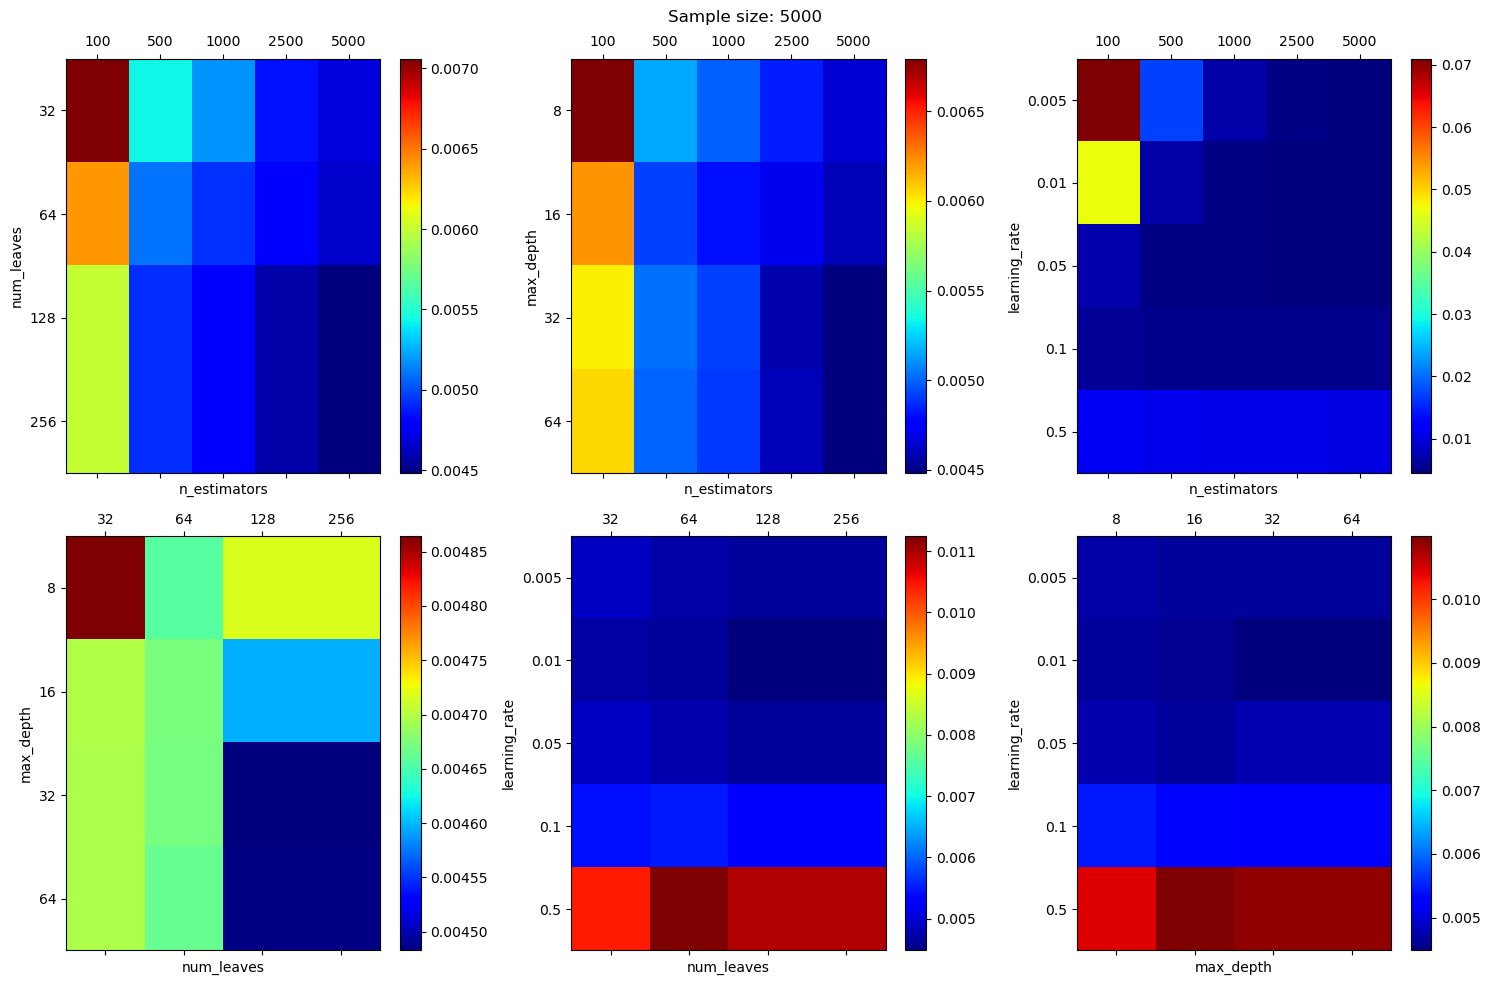

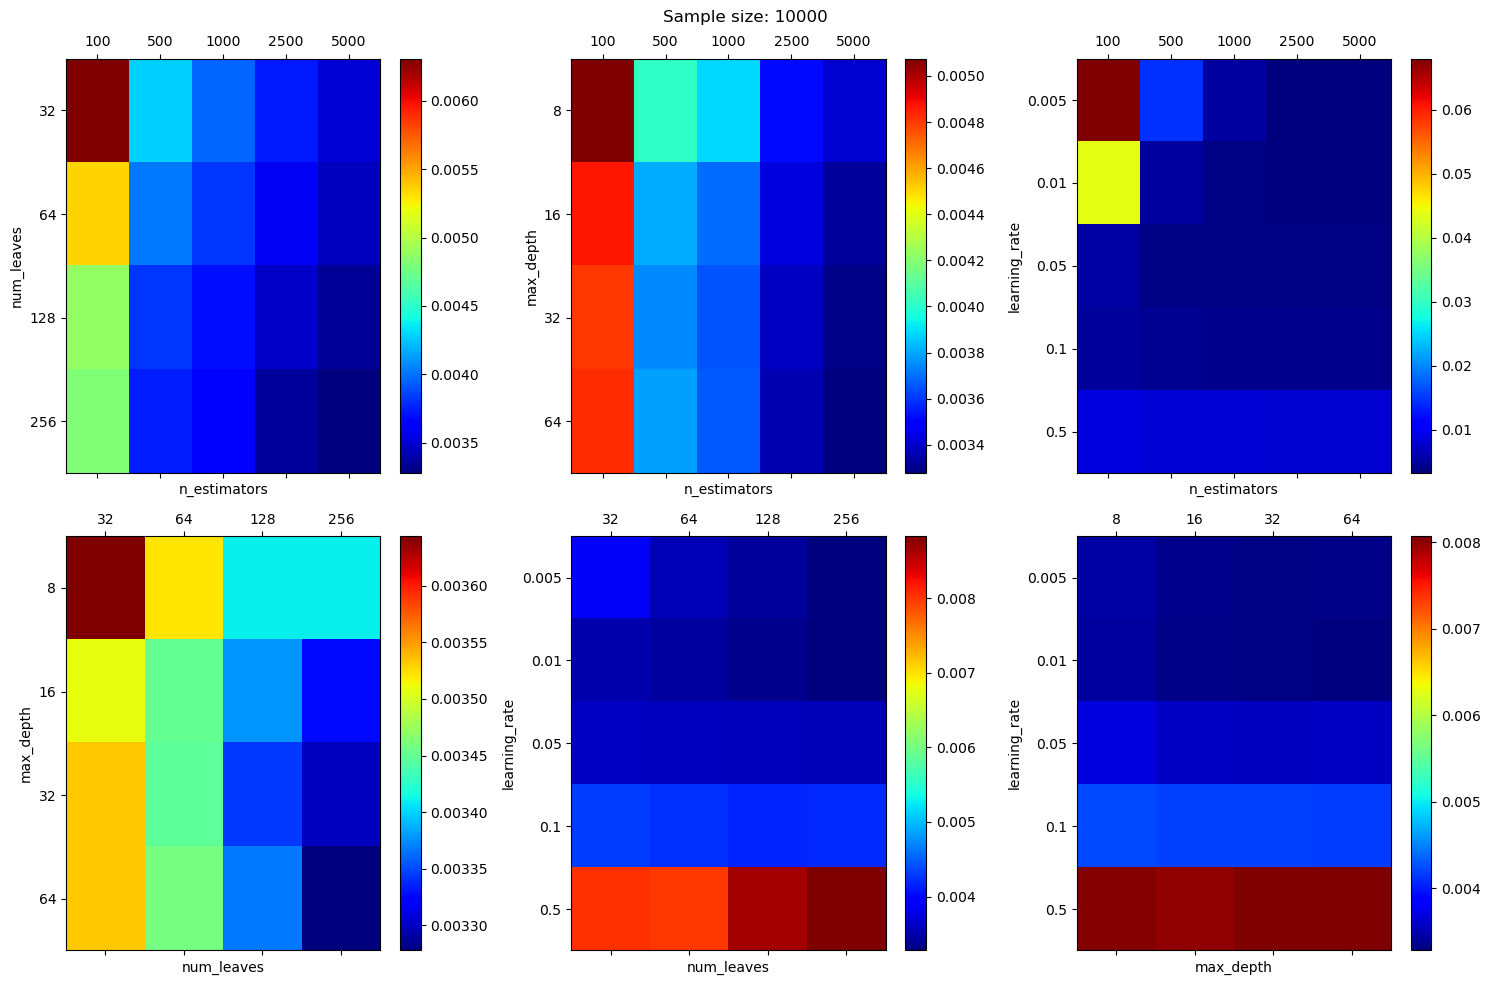

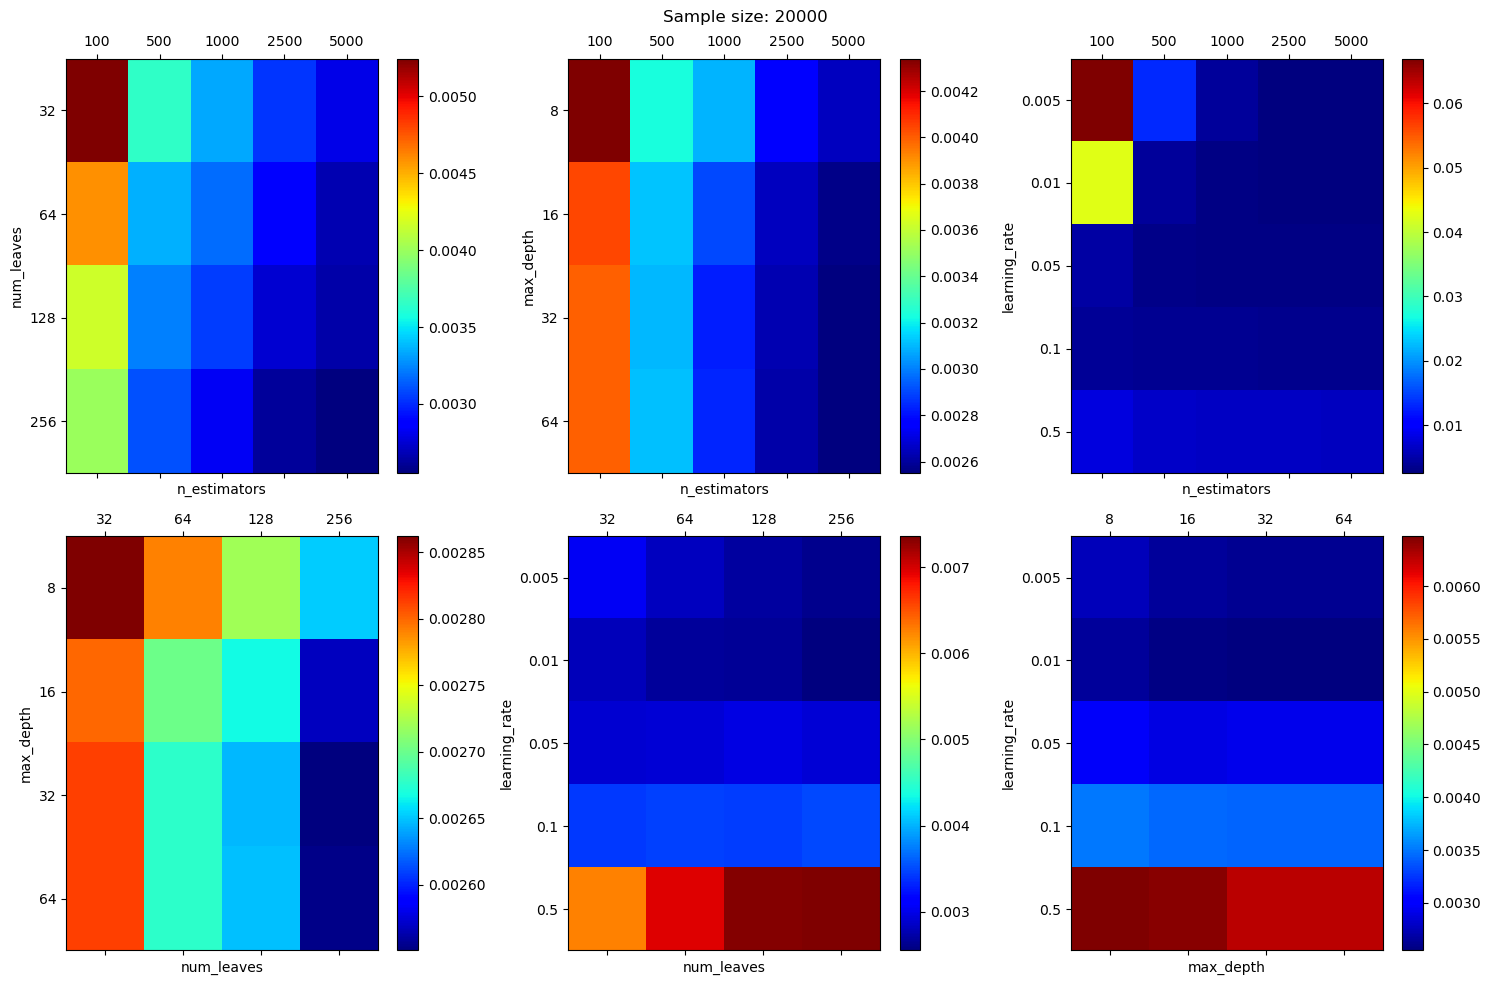

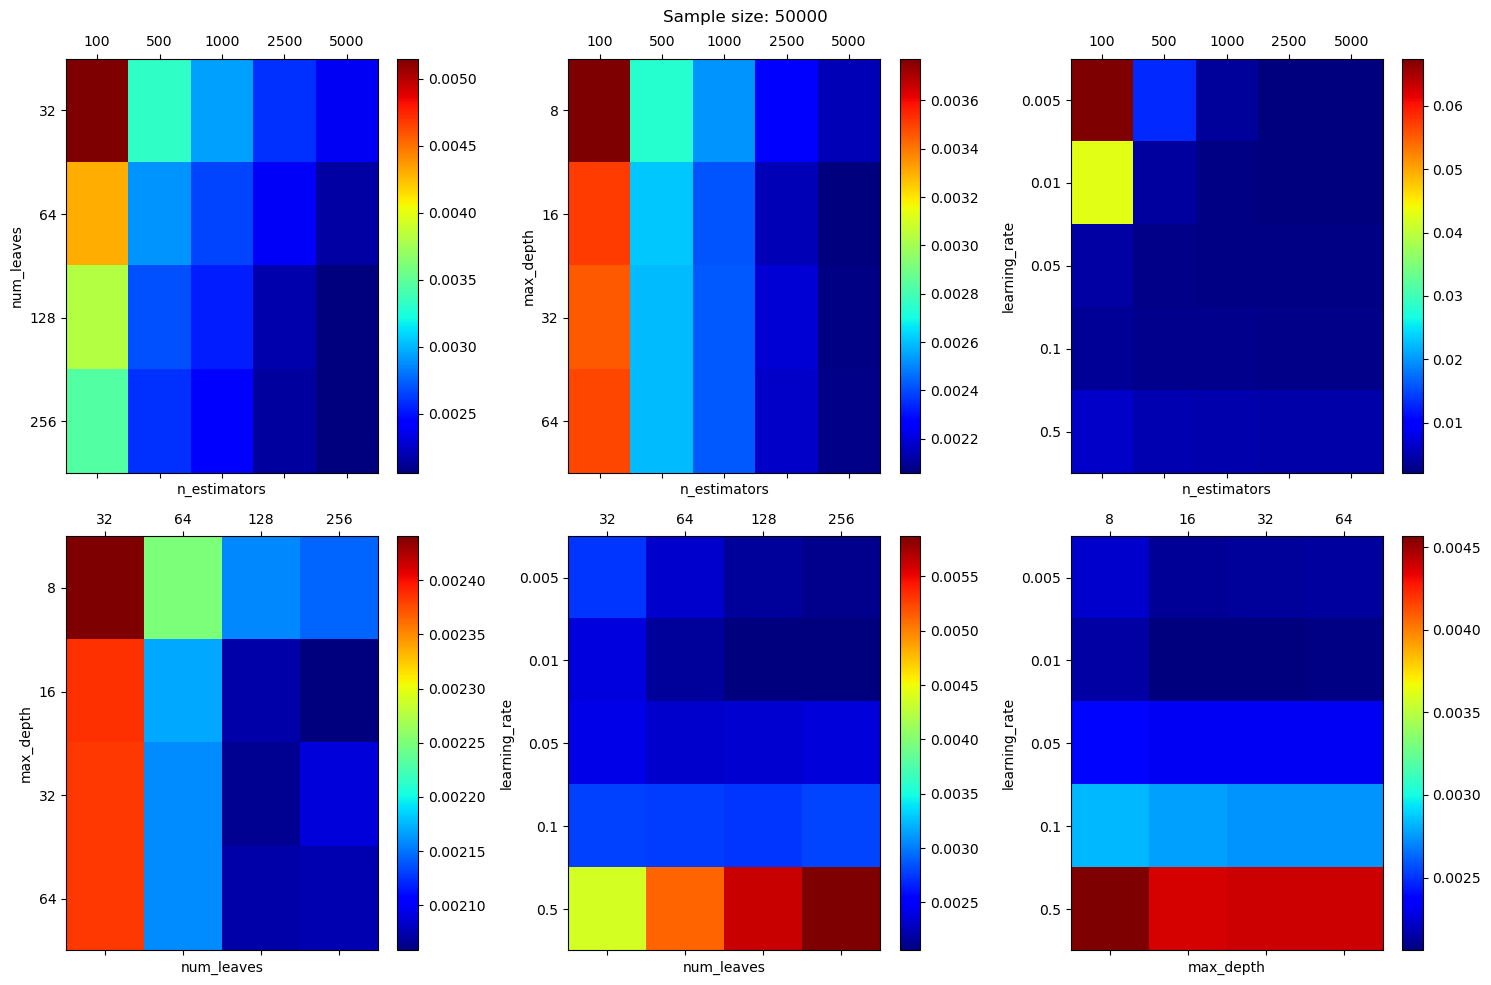

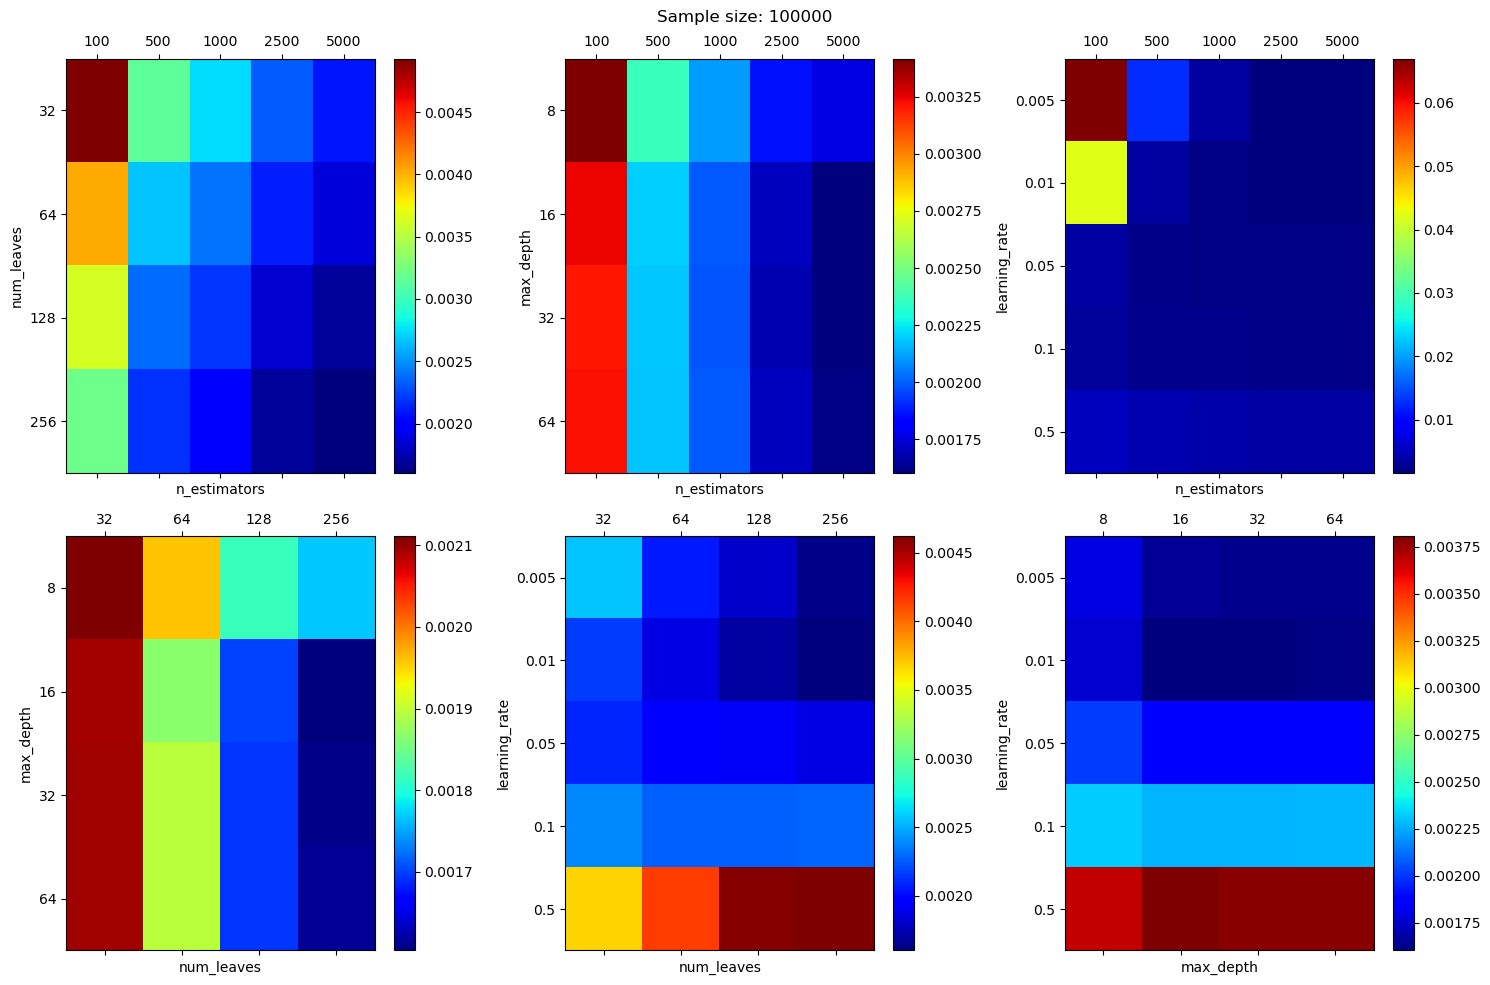

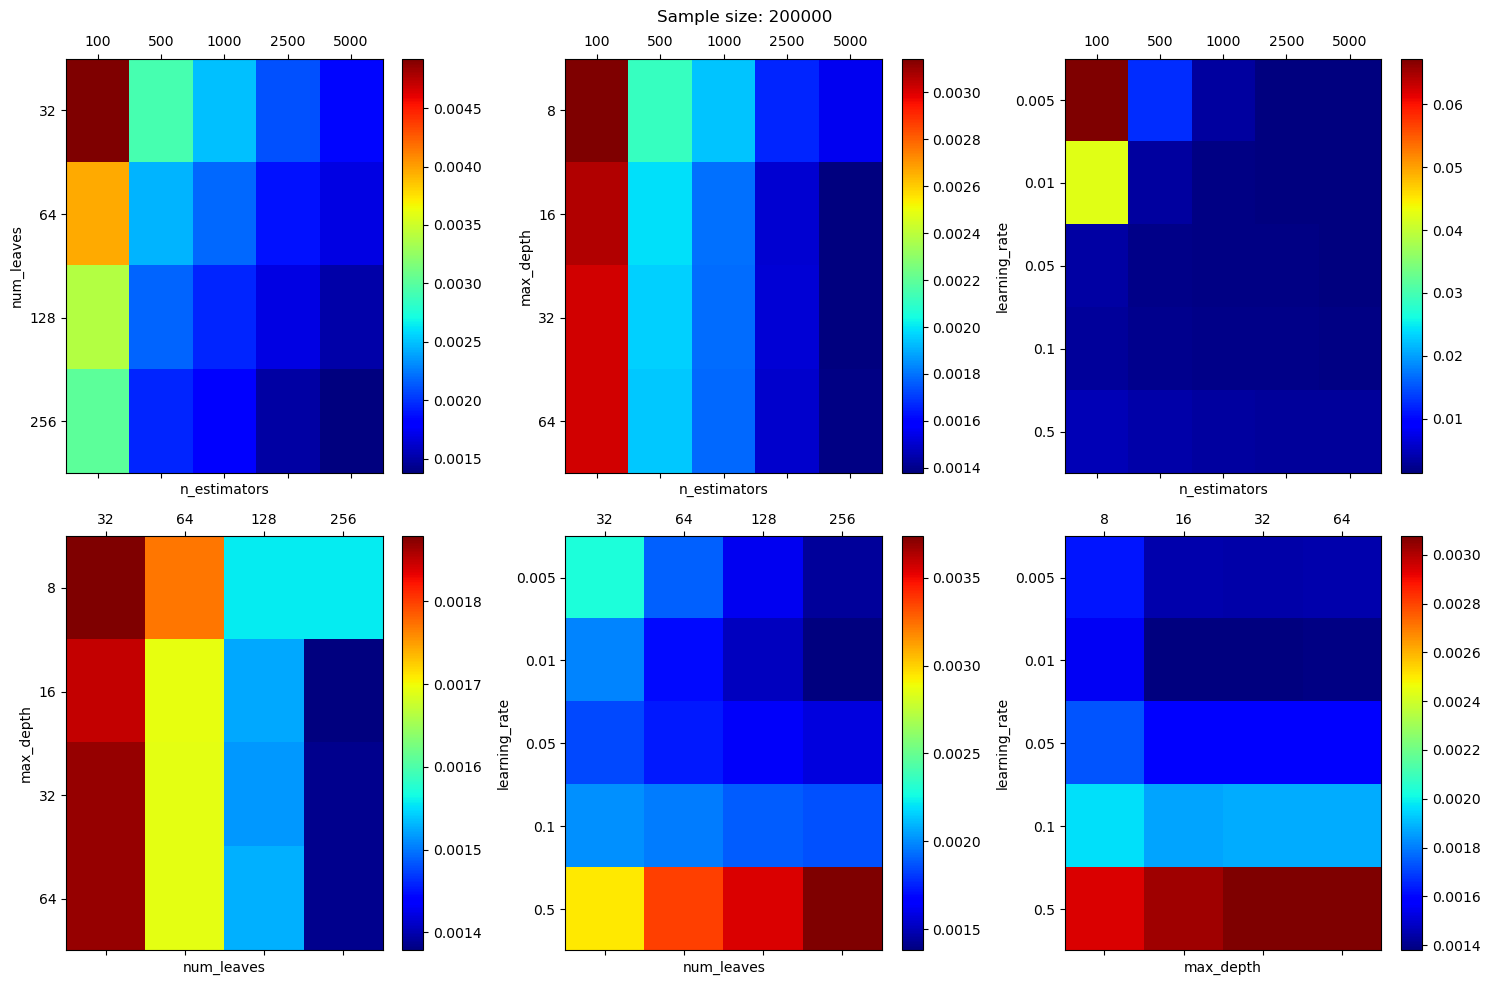

In [11]:
for id in sample_ids: 
    plot_hyperparameter_search(id, proper_training_results[id], param_grid)